In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import umap
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering")

from celldyn_qc import QcControl

%matplotlib inline


In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [ ]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

KeyboardInterrupt: 

Exception ignored in: 'pandas.io.sas._sas.Parser.read_next_page'
Traceback (most recent call last):
  File "D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py", line 762, in _read_next_page
    def _read_next_page(self):
KeyboardInterrupt: 


In [3]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn.columns if 'c_s_' in c.lower()]
celldyn = celldyn[meas_columns+mode_columns+alrt_columns+c_s_columns]
celldyn_full = celldyn[celldyn[meas_columns].isna().sum(axis=1)==0] # c_mode_cbc & c_mode_rtc are flagged

celldyn_full = QcControl.qc_rbc(celldyn_full)
celldyn_full = QcControl.qc_leuko(celldyn_full)
celldyn_full = QcControl.qc_standard_values(celldyn_full)

NameError: name 'celldyn' is not defined

In [4]:
cut_offs = pd.read_csv("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\CelldynParams.csv",delimiter=";",encoding = 'latin-1')
col_names = cut_offs.columns
cut_offs = pd.DataFrame(np.where(cut_offs == '-',np.nan,cut_offs),columns=col_names)
print(len(celldyn_full))
for c in meas_columns:
    try:
        min_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Min'].iloc[0])
        max_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Max'].iloc[0])
        if c == 'c_b_ht':
            min_val*=100
            max_val*=100
        if not pd.isna(min_val):
            celldyn_full = celldyn_full.loc[lambda x:(x[c] <= max_val) & (x[c] >= min_val)]
            print(c, len(celldyn_full))
    except IndexError:
        print(c)



print(len(celldyn_full))

NameError: name 'celldyn_full' is not defined

### Alerts

In [32]:
celldyn_full = celldyn_full.loc[~np.any(celldyn_full[c_s_columns].isin([4,5]),axis = 1)]

###  log_transformers toevoegen

In [3]:
celldyn_full = pd.read_csv("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/Data/data_no_c_s_45.csv")


In [5]:
with open("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\sample_indices.txt",'r') as f:
    samples = [int(x) for x in f.read().split("\n")[:-1]]

In [4]:
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [6]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst','c_b_mone','c_b_mon','c_b_bas',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
log_list = ['c_b_wbc','c_b_neu','c_b_seg','c_b_lym','c_b_eos',]

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))
log_scaler = FunctionTransformer(func=lambda x: np.log(x+1))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list),
                    ('log_scaler',log_scaler, log_list)]

pre_transformer = ColumnTransformer(transformer_list,remainder = 'passthrough')


In [7]:
sample_df = celldyn_full.sample(50000)
print(len(sample_df))
reduce_dim = 6


embedder_full = umap.UMAP(n_components = reduce_dim,n_neighbors = 20,
                          learning_rate = 0.1,min_dist = 0.0,metric = 'manhattan')
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(sample_df[meas_columns]) # final_columns


50000


Pipeline(steps=[('scaler_1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('wvf_scaler',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001FFCAB1B820>),
                                                  ['c_b_wvf']),
                                                 ('q_scaler',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001FFCAB1B5E0>),
                                                  ['c_b_plto', 'c_b_nicv',
                                                   'c_b_pseg', 'c_b_Pimn',
                                                   'c_b_mone', 'c_b_plti',
                                                   'c_b_MCHCr', 'c_b_pMAC',
                                                   'c_b_rb...
                                                   'c_b_nrbc', 'c_b_pbnd',
                                             

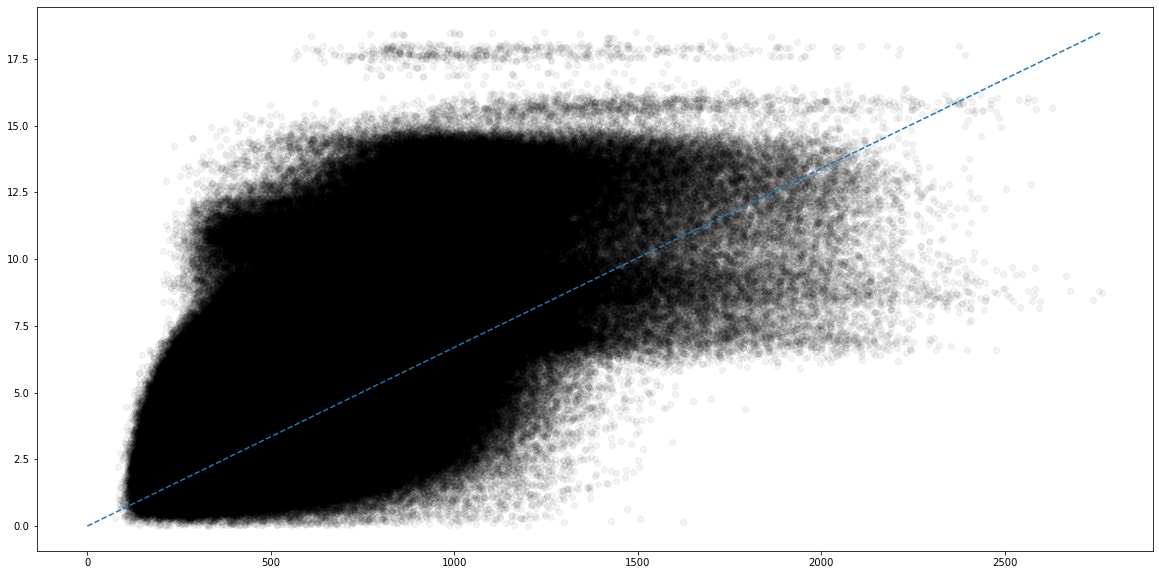

In [8]:
sample_selection = np.random.randint(0,50000,2000)

dist_df = sample_df.reset_index(drop = True)[meas_columns].loc[lambda x:x.index.isin(sample_selection)]

dist_before = distance.pdist(dist_df,metric='cityblock')
dist_after = distance.pdist(le_pipe.transform(dist_df),metric='cityblock')


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [9]:
transformed_data = le_pipe.transform(sample_df[meas_columns])

In [10]:
clusterer_embedding = KMeans(n_clusters = 5)
clusterer_embedding.fit(le_pipe.named_steps['embedder'].embedding_)

KMeans(n_clusters=5)

In [11]:
clusterer_org_dat = KMeans(n_clusters = 5)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=5)

In [12]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

In [13]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(transformed_data, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(transformed_data, clusterer_embedding.labels_)

In [14]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [15]:
print("Distance preservation overall", dist_preservation_overall)
print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], transformed_data))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.541505306454402
Intra-distance trustworthiness 1.0571214455912945
Rand score 0.7499757651153023
Adjusted Rand score 0.40460984698014457
Adjusted MI score 0.45680401644243157
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.13516136149883523
David-Bouldin ratio, higher than 1 means better clustering for embedding 3.210687674910308


In [16]:
plot_df = pd.DataFrame(data=le_pipe['embedder'].embedding_, columns=[f'd_{i}' for i in range(reduce_dim)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns+c_s_columns])
plot_df['k_means']  = clusterer_embedding.labels_
plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil(reduce_dim**2/3))

plot_df.columns

Index(['d_0', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'c_mode_cbc', 'c_mode_rtc',
       'c_mode_cd61', 'c_mode_xLyse', 'c_mode_xCnt', 'c_mode', 'c_Alrt_rrbc',
       'c_Alrt_wbc', 'c_Alrt_dif', 'c_Alrt_wvf', 'c_Alrt_fp', 'c_Alrt_bnd',
       'c_Alrt_ig', 'c_Alrt_blst', 'c_Alrt_vlym', 'c_AlrtQ_bnd', 'c_AlrtQ_ig',
       'c_AlrtQ_blst', 'c_AlrtQ_vlym', 'c_AlrtQ_fp', 'c_Alrt_wbc_pltcmp',
       'c_Alrt_pltcmp2', 'c_Alrt_rbcDlta', 'c_Alrt_pltDlta', 'c_Alrt_rbc',
       'c_Alrt_plt', 'c_Alrt_hb', 'c_Alrt_rbc_assym', 'c_Alrt_rbc_pltCmp2',
       'c_Alrt_lri', 'c_Alrt_uri', 'c_Alrt_optlri', 'c_Alrt_opturi',
       'c_Alrt_retc', 'c_Alrt_retcHI', 'c_Alrt_retcIN', 'c_s_wbc', 'c_s_wvf',
       'c_s_neu', 'c_s_seg', 'c_s_bnd', 'c_s_ig', 'c_s_lym', 'c_s_lyme',
       'c_s_vlym', 'c_s_mon', 'c_s_mone', 'c_s_blst', 'c_s_eos', 'c_s_bas',
       'c_s_nrbc', 'c_s_pneu', 'c_s_pseg', 'c_s_pbnd', 'c_s_pig', 'c_s_plym',
       'c_s_plyme', 'c_s_pvlym', 'c_s_pmon', 'c_s_pmone', 'c_s_pblst',
       'c_s_peos', '

In [17]:
from hdbscan import HDBSCAN

db_scan = HDBSCAN(min_samples= 20)
plot_df['labels'] = db_scan.fit_predict(plot_df[[f'd_{i}' for i in range(reduce_dim)]])

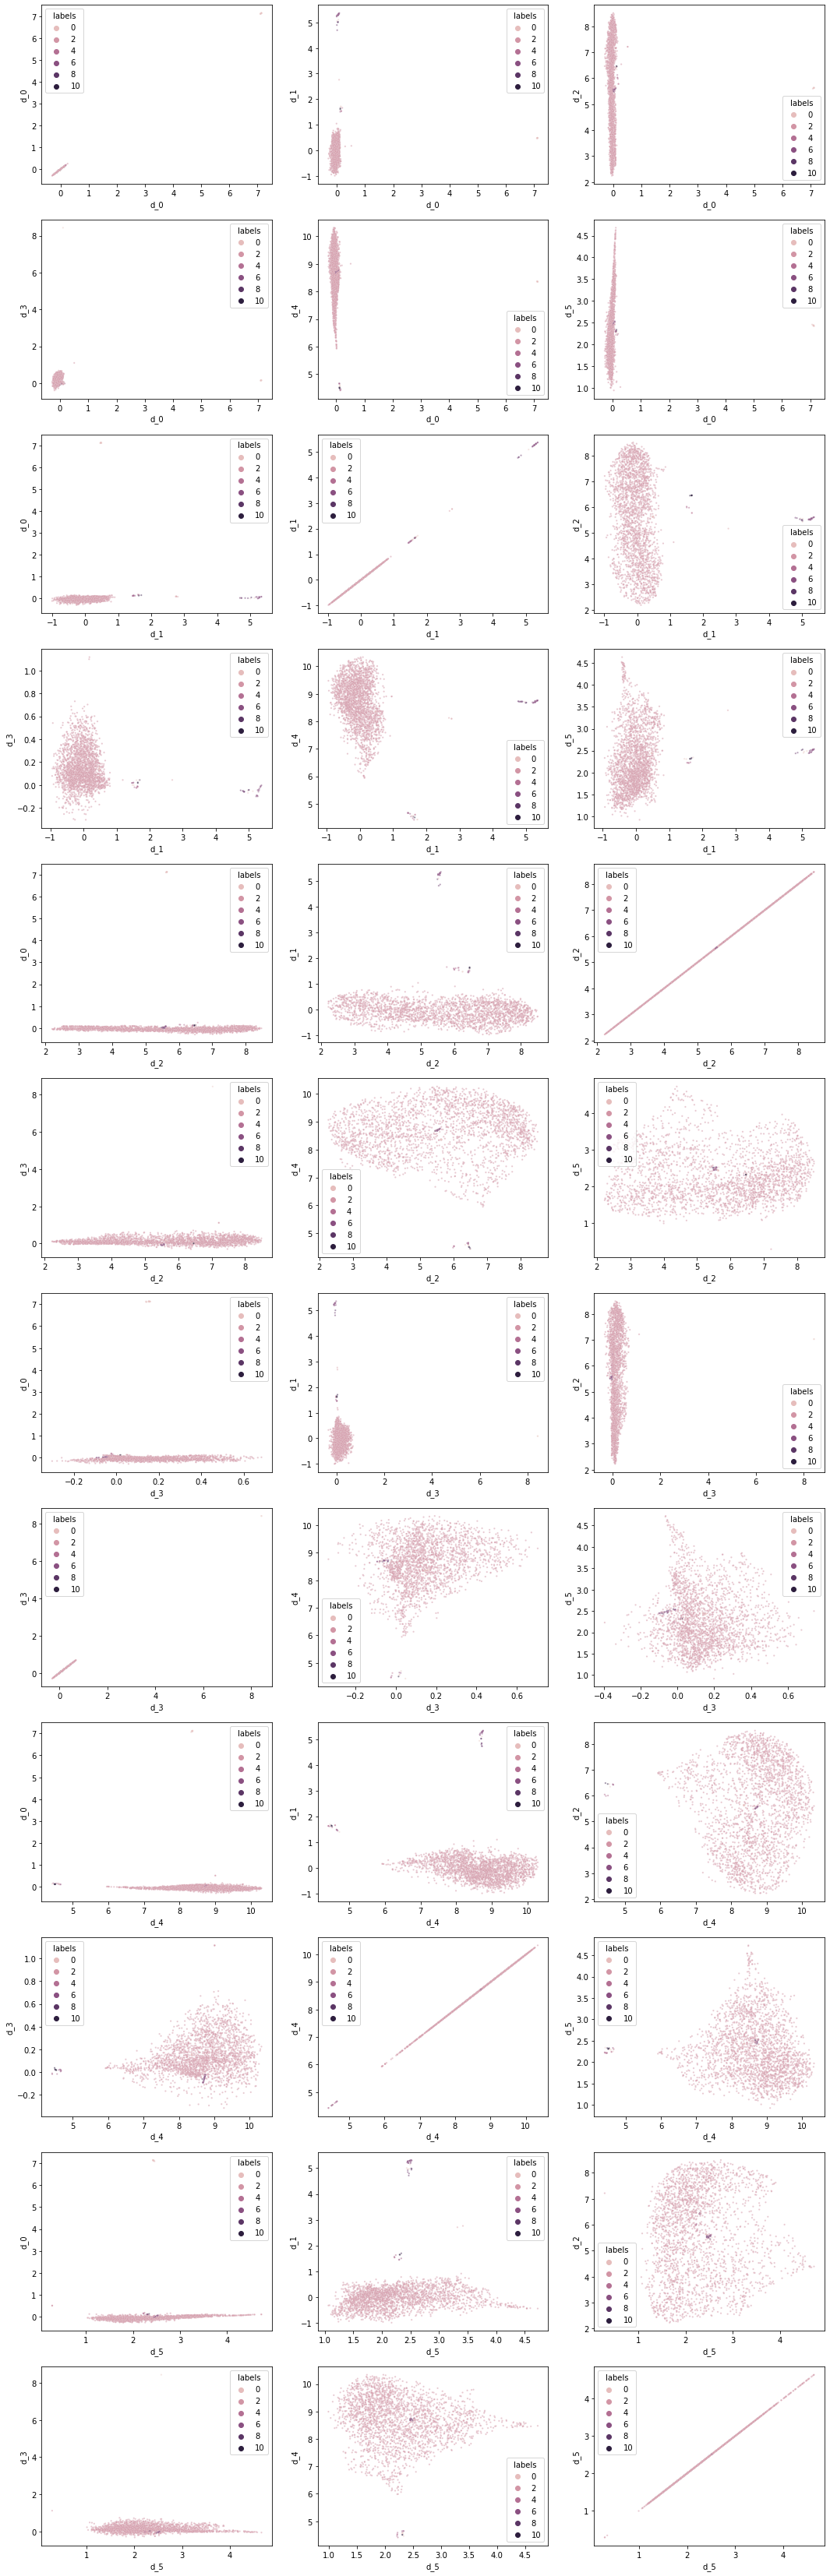

In [18]:
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='labels', alpha=0.5, s = 5)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='labels', alpha=0.5, s = 5)
        k += 1